In [1]:
# config & imports

import os, glob, time, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")

# --- paths ---
pure_train_folder = "../data/refs/ptfe_1000"   
map_folder        = "../sample"           
profile_path      = "../data/refs/profile.CSV" 
grid_manifest     = "../generated/grid_100/grid_manifest.CSV" 
out_dir           = "../results"
plot_dir          = "../plots"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# --- parallel ---
MAX_WORKERS = min(32, os.cpu_count() or 8)

# --- features / preprocessing ---
BANDS      = None       # e.g. [(4000, 3000), (1800, 800)] or None for all
DOWNSAMPLE = None       # e.g. 2 to keep every 2nd point
USE_SGDER  = True
USE_SNV    = True
SG_WIN, SG_POLY = 15, 2

# --- PCA / thresholds ---
VAR_TARGET     = 0.999
MAX_COMPONENTS = 1000
Q_THRESH_PERC  = 99.5
T2_THRESH_PERC = 99.5
COMBINE_Q_T2   = True     # zQ + zT2 for scoring

print("config ok → outputs:", out_dir)


config ok → outputs: ../results


In [2]:
# loaders & utils

def load_xy_header_aware(fn):
    """2-col CSV (wavenumber, absorbance), robust to presence/absence of header."""
    try:
        df = pd.read_csv(fn, header=0)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(wn).any() or np.isnan(ab).any(): raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        m = ~(np.isnan(wn) | np.isnan(ab))
        wn, ab = wn[m], ab[m]
    order = np.argsort(wn)
    return wn[order], ab[order]

def strict_indexed_list(folder, N):
    """Return files in exact *_001.CSV .. *_NNN.CSV order (required)."""
    files = []
    for idx in range(1, N+1):
        hit = glob.glob(os.path.join(folder, f"*_{idx:03d}.CSV"))
        if not hit:
            raise FileNotFoundError(f"Missing spectrum for index {idx:03d} in {folder}")
        files.append(hit[0])
    return files

def band_mask(wn, bands):
    if not bands: return np.ones_like(wn, dtype=bool)
    m = np.zeros_like(wn, dtype=bool)
    for lo, hi in bands:
        lo, hi = min(lo,hi), max(lo,hi)
        m |= (wn >= lo) & (wn <= hi)
    return m

def concat_bands(wn, y, bands, ds=None):
    wn_ref, y_ref = (wn[::ds], y[::ds]) if (ds and ds>1) else (wn, y)
    m = band_mask(wn_ref, bands)
    return wn_ref[m], y_ref[m]


In [3]:
# load pure PTFE set

pure_files = sorted(glob.glob(os.path.join(pure_train_folder, "*.CSV")))
assert len(pure_files) > 0, f"No pure files in {pure_train_folder}"

wn0, _ = load_xy_header_aware(pure_files[0])

def interp_and_band(fn, wn_ref, bands, ds):
    wn_i, y_i = load_xy_header_aware(fn)
    y_interp = np.interp(wn_ref, wn_i, y_i)
    wn_sel, y_sel = concat_bands(wn_ref, y_interp, bands, ds)
    return wn_sel, y_sel

t0 = time.time()
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(interp_and_band, f, wn0, BANDS, DOWNSAMPLE): i
            for i, f in enumerate(pure_files)}
    outs = [None]*len(pure_files)
    for fut in as_completed(futs):
        outs[futs[fut]] = fut.result()

wn_sel = outs[0][0]
X_pure = np.vstack([o[1] for o in outs])
print(f"pure PTFE matrix: {X_pure.shape}  built in {time.time()-t0:.2f}s")


pure PTFE matrix: (1000, 1724)  built in 0.64s


In [4]:
# preprocessing

from scipy.signal import savgol_filter
def snv(A):
    mu = A.mean(axis=1, keepdims=True)
    sd = A.std(axis=1, keepdims=True) + 1e-12
    return (A - mu) / sd

def sg_derivative(A, win=15, poly=2, dx=1.0):
    return savgol_filter(A, window_length=win, polyorder=poly, deriv=1,
                         delta=dx, axis=1)

Xtr = X_pure.copy()
if USE_SGDER: Xtr = sg_derivative(Xtr, win=SG_WIN, poly=SG_POLY, dx=1.0)
if USE_SNV:   Xtr = snv(Xtr)
print("preprocessing:", ("SG-deriv → " if USE_SGDER else "") + ("SNV" if USE_SNV else "none"))


preprocessing: SG-deriv → SNV


In [5]:
# PCA training + fixed thresholds

from sklearn.decomposition import PCA

pca_full = PCA(n_components=min(MAX_COMPONENTS, Xtr.shape[1]), svd_solver="full", random_state=0)
pca_full.fit(Xtr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
k = int(np.searchsorted(cumvar, VAR_TARGET) + 1)
k = min(k, MAX_COMPONENTS)

pca = PCA(n_components=k, svd_solver="full", random_state=0)
T = pca.fit_transform(Xtr)
Xtr_hat = pca.inverse_transform(T)
E = Xtr - Xtr_hat
Q_train = np.sum(E**2, axis=1)
lam = pca.explained_variance_
T2_train = np.sum((T**2)/(lam+1e-15), axis=1)

Q_thresh  = np.percentile(Q_train,  Q_THRESH_PERC)
T2_thresh = np.percentile(T2_train, T2_THRESH_PERC)

print(f"components: {k} (cum.var={cumvar[k-1]:.4f})  thresholds: Q@{Q_THRESH_PERC}%={Q_thresh:.3g}, T²@{T2_THRESH_PERC}%={T2_thresh:.3g}")


components: 196 (cum.var=0.9990)  thresholds: Q@99.5%=0.00389, T²@99.5%=416


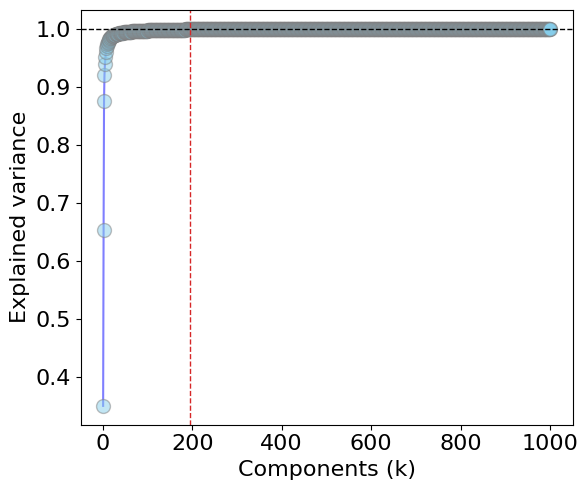

Saved: ../plots/fig4a.jpg


In [6]:
# PCA scree plot 
import matplotlib.pyplot as plt

# --- Local style controls ---
FIGSIZE     = (6, 5)
DPI         = 500
FONT_LABEL  = 16
FONT_TICK   = 16
LINE_COLOR  = "blue"   
MARKER_EDGE = "gray"         
MARKER_FACE = "skyblue"   
MARKER_SIZE = 10           
ALPHA_LINE  = 0.5          
HL_COLOR    = "black"          
VL_COLOR    = "tab:red"    

# --- Plot ---
plt.figure(figsize=FIGSIZE)

plt.plot(
    np.arange(1, len(cumvar) + 1), cumvar,
    color=LINE_COLOR,
    marker="o",
    markersize=MARKER_SIZE,
    markerfacecolor=MARKER_FACE,
    markeredgecolor=MARKER_EDGE,
    alpha=ALPHA_LINE,
    lw=1.5
)

plt.axhline(VAR_TARGET, color=HL_COLOR, ls="--", lw=1)
plt.axvline(k, color=VL_COLOR, ls="--", lw=1)

# --- Labels & title ---
plt.xlabel("Components (k)", fontsize=FONT_LABEL)
plt.ylabel("Explained variance", fontsize=FONT_LABEL)

# --- Tick sizes ---
plt.xticks(fontsize=FONT_TICK)
plt.yticks(fontsize=FONT_TICK)

plt.tight_layout()

# --- Save ---
path_scree = os.path.join(plot_dir, "fig4a.jpg")
plt.savefig(path_scree, dpi=DPI)
plt.show()

print(f"Saved: {path_scree}")


In [7]:
# load map (001..N), preprocess, project
# xy order from profile

prof = pd.read_csv(profile_path, header=None)
prof.columns = ["X","Y","_"]
N = len(prof)

# enforce exact indexing order even if disk list is unsorted
def strict_indexed_list(folder, N):
    files = []
    for idx in range(1, N+1):
        hit = glob.glob(os.path.join(folder, f"*_{idx:03d}.CSV"))
        if not hit:
            raise FileNotFoundError(f"missing spectrum for index {idx:03d} in {folder}")
        files.append(hit[0])
    return files

map_files = strict_indexed_list(map_folder, N)

def map_row(fn, wn_ref, bands, ds):
    wn_i, y_i = load_xy_header_aware(fn)
    yi = np.interp(wn_ref, wn_i, y_i)
    _, y_sel = concat_bands(wn_ref, yi, bands, ds)
    return y_sel

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(map_row, f, wn0, BANDS, DOWNSAMPLE): i for i, f in enumerate(map_files)}
    rows = [None]*len(map_files)
    for fut in as_completed(futs):
        rows[futs[fut]] = fut.result()

X_map = np.vstack(rows)

# same preprocessing
Xmp = X_map.copy()
if USE_SGDER: Xmp = sg_derivative(Xmp, win=SG_WIN, poly=SG_POLY, dx=1.0)
if USE_SNV:   Xmp = snv(Xmp)

T_map = pca.transform(Xmp)
Xmp_hat = pca.inverse_transform(T_map)
E_map = Xmp - Xmp_hat
Q_map = np.sum(E_map**2, axis=1)
T2_map = np.sum((T_map**2)/(lam+1e-15), axis=1)

# continuous score
if COMBINE_Q_T2:
    zQ  = (Q_map  - Q_train.mean()) / (Q_train.std()  + 1e-12)
    zT2 = (T2_map - T2_train.mean()) / (T2_train.std() + 1e-12)
    combo = zQ + zT2
else:
    combo = Q_map

pca_out = pd.DataFrame({
    "index": np.arange(1, N+1),
    "X": prof["X"], "Y": prof["Y"],
    "Q_residual": Q_map,
    "T2": T2_map,
    "combo_score": combo,
})


In [8]:
# F1-opt threshold & final predictions

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# attach GT (hbn_percent) for threshold selection
man = pd.read_csv(grid_manifest).rename(columns={"hbn_percent":"hbn_percent_true"})
if "index" not in man.columns: man["index"] = np.arange(1, len(man)+1)
merged = pca_out.merge(man[["index","hbn_percent_true"]], on="index", how="left")

# binary GT: impurity if hBN ≥ 0.5% (manifest in 0..100 scale)
merged["gt_imp"] = (merged["hbn_percent_true"] >= 0.5).astype(int)

scores = merged["combo_score"].to_numpy()
y_true = merged["gt_imp"].to_numpy()

# scan thresholds, pick F1-best
ths = np.linspace(scores.min(), scores.max(), 300)
best = None
for t in ths:
    y_hat = (scores >= t).astype(int)
    f1 = f1_score(y_true, y_hat, zero_division=0)
    if (best is None) or (f1 > best[3]):
        p = precision_score(y_true, y_hat, zero_division=0)
        r = recall_score(y_true, y_hat, zero_division=0)
        acc = accuracy_score(y_true, y_hat)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
        best = (t, p, r, f1, acc, tn, fp, fn, tp)

BEST_T, P, R, F1, ACC, TN, FP, FN, TP = best
merged["pred_impurity"] = (scores >= BEST_T).astype(int)

# save core tables & threshold
pca_out = merged.drop(columns=["gt_imp"])  # keep GT columns and preds together
pca_out.to_csv(os.path.join(out_dir, "pca_pred-gt.csv"), index=False)
with open(os.path.join(out_dir, "f1opt_threshold.json"), "w") as f:
    json.dump({"best_f1_threshold": float(BEST_T),
               "accuracy": float(ACC), "precision": float(P),
               "recall": float(R), "f1": float(F1),
               "TN": int(TN), "FP": int(FP), "FN": int(FN), "TP": int(TP)}, f, indent=2)

print(f"F1-opt threshold = {BEST_T:.3f}")
print(f"Acc={ACC:.3f}  Prec={P:.3f}  Rec={R:.3f}  F1={F1:.3f}  [TN={TN}, FP={FP}, FN={FN}, TP={TP}]")


F1-opt threshold = 1009.270
Acc=0.920  Prec=1.000  Rec=0.733  F1=0.846  [TN=70, FP=0, FN=8, TP=22]


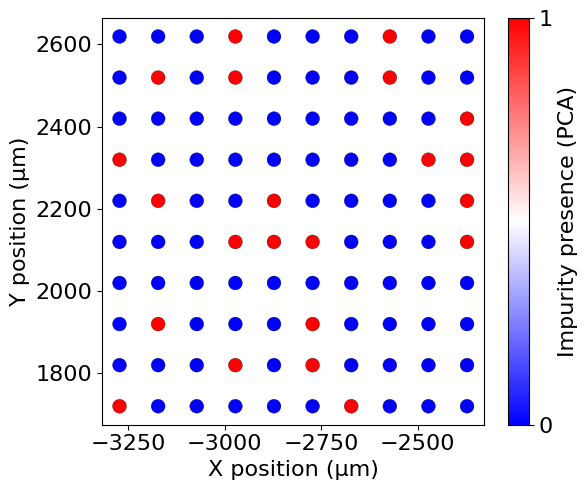

Saved: ../plots/fig4c.jpg


In [9]:
# Binary impurity map

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

# --- Color palette (gray = pure, red = impure) ---
palette = {0: "#B0B0B0", 1: "#D62728"}  
col = [palette[v] for v in pca_out["pred_impurity"]]

plt.figure(figsize=(6, 5))

# --- Scatter plot ---
sc = plt.scatter(
    pca_out["X"], pca_out["Y"],
    c=pca_out["pred_impurity"],
    cmap="bwr",          # use red/blue colormap for colorbar consistency
    s=100,               # marker size
    edgecolor="k",
    linewidth=0.2
)

# --- Colorbar ---
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.set_label("Impurity presence (PCA)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# --- Axis labels ---
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)

# --- Tick font sizes ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# --- Tick intervals (~5 per axis) ---
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save figure ---
path_bin = os.path.join(plot_dir, "fig4c.jpg")
plt.savefig(path_bin, dpi=500)
plt.show()

print("Saved:", path_bin)


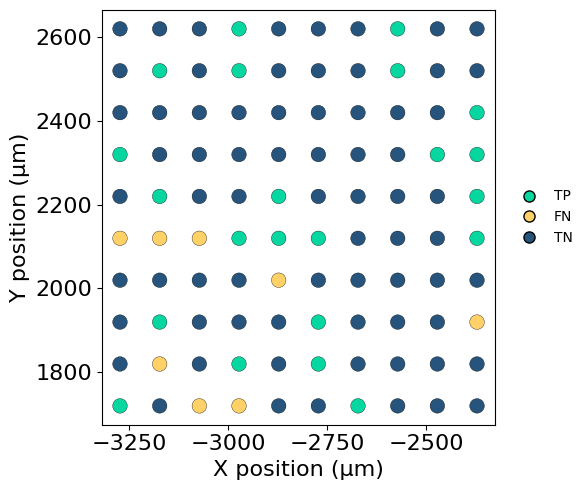

In [13]:
# PCA detection results (TN/FP/FN/TP)

GT_IMPURITY_MIN = 1.0
FIGSIZE, MSIZE, EDGE_W, FONT_L = (6,5), 110, 0.25, 16

df2 = pca_out.copy()
valid_gt = ~pd.isna(df2["hbn_percent_true"])
df2["gt_impurity"]   = np.where(valid_gt, (df2["hbn_percent_true"]>=GT_IMPURITY_MIN).astype(int), -1)
df2["pred_impurity"] = df2["pred_impurity"].astype(int)

# -1 unknown, 0 TN, 1 FP, 2 FN, 3 TP
cat = np.full(len(df2), -1, dtype=int)
m = valid_gt
cat[m & (df2["gt_impurity"]==0) & (df2["pred_impurity"]==0)] = 0
cat[m & (df2["gt_impurity"]==0) & (df2["pred_impurity"]==1)] = 1
cat[m & (df2["gt_impurity"]==1) & (df2["pred_impurity"]==0)] = 2
cat[m & (df2["gt_impurity"]==1) & (df2["pred_impurity"]==1)] = 3

palette    = { -1:"#CCCCCC", 0:"#26547c", 1:"#ef476f", 2:"#ffd166", 3:"#06d6a0" }
labels  = { -1:"Unknown GT", 0:"TN", 1:"FP", 2:"FN", 3:"TP" }

plt.figure(figsize=FIGSIZE)
colors = [palette[v] for v in cat]
plt.scatter(df2["X"], df2["Y"], c=colors, s=MSIZE, edgecolor="k", linewidth=EDGE_W)
plt.xlabel("X position (µm)", fontsize=FONT_L)
plt.ylabel("Y position (µm)", fontsize=FONT_L)
plt.xticks(fontsize=FONT_L); plt.yticks(fontsize=FONT_L)

order = [3,2,1,0,-1]
handles = [Line2D([0],[0], marker='o', color='w', label=labels[k],
                  markerfacecolor=palette[k], markeredgecolor='k', markersize=8)
           for k in order if (cat==k).any()]
plt.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02,0.5), frameon=False)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
out_fig = os.path.join(plot_dir, "fig4d.jpg")
plt.savefig(out_fig, dpi=500)
plt.show()



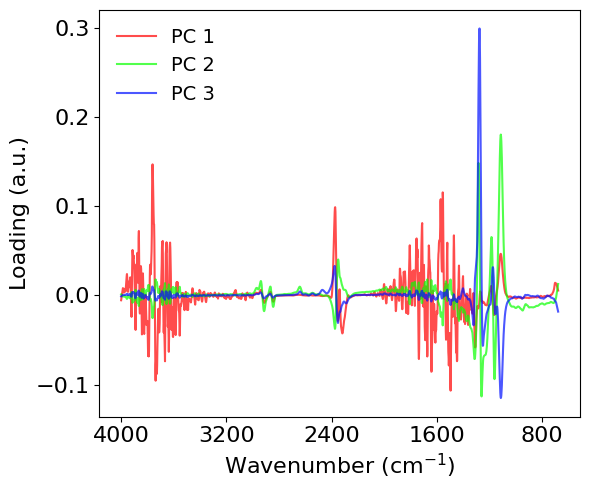

Saved: ../plots/fig4b.jpg


In [11]:
# PCA loadings (spectral shapes)
# pca.components_ shape: (k, n_features) where features follow wn_sel (after band/DS)

L = pca.components_.T   # (n_features × k)
wn_feat = wn_sel        # wavenumber axis for features (preprocessed ordering)

# === PCA loadings plot (publication ready) ===
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

# --- Local style controls ---
FIGSIZE       = (6, 5)
DPI           = 500
FONT_LABEL    = 16
FONT_TICK     = 16
FONT_LEGEND   = 14
FONT_TITLE    = 16
LINE_WIDTH    = 1.5
LINE_ALPHA    = 0.7
CMAP_NAME     = "hsv"   # choose e.g. 'tab10', 'viridis', 'plasma', 'Set2'
N_COLORS      = 10        # number of colors to sample from colormap

# --- Generate line colors ---
colors = cm.get_cmap(CMAP_NAME, N_COLORS)

# --- Plot ---
plt.figure(figsize=FIGSIZE)

n_to_plot = min(3, L.shape[1])  # plot up to 4 PCs
for i in range(n_to_plot):
    plt.plot(
        wn_feat, L[:, i],
        color=colors(i / n_to_plot),       # color for each PC line
        label=f"PC {i+1}",
        linewidth=LINE_WIDTH,
        alpha=LINE_ALPHA
    )

# --- IR convention: high → low wavenumber ---
plt.gca().invert_xaxis()

# --- Labels & title ---
plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=FONT_LABEL)
plt.ylabel("Loading (a.u.)", fontsize=FONT_LABEL)

# --- Tick font sizes ---
plt.xticks(fontsize=FONT_TICK)
plt.yticks(fontsize=FONT_TICK)

# --- Legend ---
plt.legend(frameon=False, fontsize=FONT_LEGEND, loc="best")

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save ---
path_load = os.path.join(plot_dir, "fig4b.jpg")
plt.savefig(path_load, dpi=DPI)
plt.show()

print(f"Saved: {path_load}")

